# Playing with UCI Bike Sharing Data

Links:
- [Data source](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

In [13]:
import pandas as pd

from download_data import download_data
import seaborn as sns
from matplotlib import pyplot as plt

Download data from the source to the local `data` directory

In [ ]:
local_data_dir = download_data()

Import data

In [8]:
raw_data_path = local_data_dir / "day.csv"
lbl_date = "dteday"
lbl_count_of_rental_bikes = "cnt"
raw_data = pd.read_csv(raw_data_path, parse_dates=[lbl_date])
raw_data.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), floa

In [18]:
raw_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [20]:
raw_data.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [14]:
split_time = raw_data[lbl_date].max() - pd.DateOffset(days=30)
data_train = raw_data.pipe(lambda df: df[df[lbl_date] < split_time])
data_train.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
695,696,2012-11-26,4,1,11,0,1,1,1,0.313333,0.339004,0.535417,0.046650,337,4750,5087
696,697,2012-11-27,4,1,11,0,2,1,2,0.291667,0.281558,0.786667,0.237562,123,3836,3959
697,698,2012-11-28,4,1,11,0,3,1,1,0.296667,0.289762,0.506250,0.210821,198,5062,5260
698,699,2012-11-29,4,1,11,0,4,1,1,0.280870,0.298422,0.555652,0.115522,243,5080,5323
699,700,2012-11-30,4,1,11,0,5,1,1,0.298333,0.323867,0.649583,0.058471,362,5306,5668


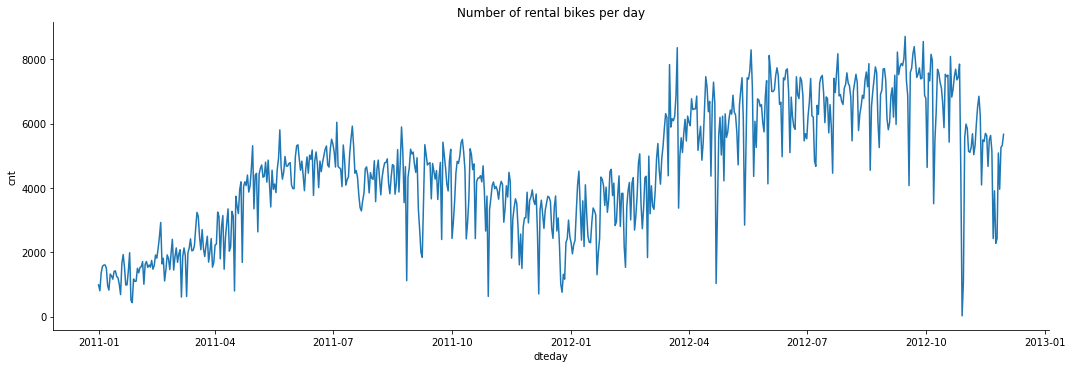

In [17]:
sns.relplot(
    x=lbl_date,
    y=lbl_count_of_rental_bikes,
    kind="line",
    aspect=3,
    data=data_train
)
plt.title("Number of rental bikes per day")
plt.show()

In [24]:
MAX_RENTALS_PER_BIKE_PER_DAY = 12
lbl_nr_of_bikes_needed_per_day = "number of bikes needed per day"
data_train = data_train.assign(
    **{lbl_nr_of_bikes_needed_per_day: lambda df: df[lbl_count_of_rental_bikes] / MAX_RENTALS_PER_BIKE_PER_DAY}
)

In [26]:
max_nr_of_bikes_needed = data_train[lbl_nr_of_bikes_needed_per_day].max()
print(f"Max number of bikes needed over all days in the data: {max_nr_of_bikes_needed:.0f}")

Max number of bikes needed over all days in the data: 726


In [32]:
alpha = 0.95
quantile_nr_of_bikes_needed = data_train[lbl_nr_of_bikes_needed_per_day].quantile(alpha)

print(f"{alpha:.0%} quantile number of bikes needed over all days in the data: {quantile_nr_of_bikes_needed:.0f}")

95% quantile number of bikes needed over all days in the data: 632
